# Primary settings

In [1]:
import os, copy
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from variables import *

# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False
font_path = "C:/Windows/Fonts/HMFMMUEX.TTC"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

np.set_printoptions(threshold=np.inf)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Torch version: ', torch.__version__); print('Device name:', device, '/' + torch.cuda.get_device_name(0))
print('Device spec:', torch.cuda.get_device_properties(0)); print('Current cuda device index:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Torch version:  1.11.0
Device name: cuda /NVIDIA GeForce GTX 1080
Device spec: _CudaDeviceProperties(name='NVIDIA GeForce GTX 1080', major=6, minor=1, total_memory=8191MB, multi_processor_count=20)
Current cuda device index: 0
Count of using GPUs: 1


# Dataset에 대한 기본적인 분석

- 데이터셋 확인
    - 데이터가 어떻게 구성되어 있는 지 확인
    - 결측치는 없는가? 잘 정제되어있는가? 오기는 없는가? 등
- 탐색적 데이터 분석(EDA, Exploratory Data Analysis)
    - 여러 feature들을 개별적으로 분석하고, feature들 간의 `상관관계`를 확인
    - matplotlib, seaborn 등으로 시각화하여 insight 얻기
- 특성 공학(Feature Engineering)
    - one-hot encoding, class로 나누기, 구간으로 나누기, 텍스트 데이터 처리 등

## 데이터셋 확인

- 데이터의 수와 종류 파악하기
- 어떻게 구성되어 있는 지 data frame을 활용해 확인해보자.

### 데이터셋 예제

In [2]:
# 데이터셋 예제
train_df = pd.read_csv(train_data_path, sep='\t')
valid_df = pd.read_csv(valid_data_path, sep='\t')
train_df.head(5)

,문장,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean,개인지칭
0,일안하는 시간은 쉬고싶어서 그런게 아닐까,0,0,0,0,0,0,0,0,0,1,0
1,아동성범죄와 페도버는 기록바 끊어져 영원히 고통 받는다. 무슬림 50퍼 근친이다. ...,0,0,0,0,0,0,1,0,0,0,0
2,루나 솔로앨범 나왔을 때부터 머모 기운 있었음 ㅇㅇ Keep o doin 진짜 띵...,0,0,0,0,0,0,0,0,0,1,0
3,홍팍에도 어버이연합인가 보내요 뭐 이런뎃글 있는데 이거 어버이연합측에 신고하면 그쪽...,0,0,0,0,0,0,0,0,0,1,0
4,아놔 왜 여기 댓들은 다 여자들이 김치녀라고 먼저 불렸다! 여자들은 더 심하게 그런...,1,0,0,0,0,0,0,0,0,0,0


### 데이터셋 Overview
- 혐오 표현은 “특정 사회적 (소수자) 집단에 대한 적대적 발언, 조롱, 희화화, 편견을 재생산하는 표현”으로 정의  
    - 혐오의 대상이 속한 집단을 명확히 지칭하는 비하·차별발언  
    - 대상에 대한 고정관념 (e.g. 동양인은 수학 잘하지 않아?, 역시 흑형이라 운동을 잘하네)  
    - 대상의 특성이나 성향을 특정한 통념에 고착시키는 발언 (e.g. 여자는 집에서 애나 봐야지!, 임신은 축복이지!, 게이는 잘생겨야지)  
    - 화자 스스로를 자조적으로 표현하는 경우는 혐오 발언이 아님 (e.g. 아 내가 급식충이다!)  
- 단일 데이터는 [혐오표현, 악플/욕설, clean]으로 분류될 수 있으며, 혐오 표현은 다중 레이블(multi-label)로 전문가 집단을 통해 레이블링되었습니다.
- 10139:3929:4674로 혐오표현, 악플/욕설, clean으로 분류되며 혐오표현+악플/욕설을 악성문장이라고 한다면, 악성문장과 clean의 비율은 대략 1 : 2.2이다. 악성 문장 데이터가 clean 데이터의 약 2.2배가량이다. 
- 개인 지칭 여부
    - `혐오 및 욕설의 대상`이 `특정 인물을 지칭`하고, `그 대상을 대중들이 누구인지 눈치챌 수 있을 경우` '개인 지칭' 항목으로 추가 태깅하였습니다. 
    - 즉, 개인 지칭만으로 태깅된 문장은 없습니다.
    - 즉, clean 데이터는 개인 지칭 태깅이 되어 있지 않습니다.
- 태깅 결과는 100%의 정확도를 보장하지 않으므로 확인 필요!

In [3]:
train_length = len(train_df); valid_length = len(valid_df); total_length = train_length + valid_length
print(f'total # of train data: {train_length}\ntotal # of valid data: {valid_length}\ntotal # of data: {total_length}')

total # of train data: 15005
total # of valid data: 3737
total # of data: 18742


In [4]:
# 각 category별 현황
con_1 = []; con_2 = []
for category in categories:
    con_1.append(train_df[category].value_counts()[1])
col_1 = copy.deepcopy(categories); idx_1 = ['num']; train_table = pd.DataFrame([con_1], columns=col_1, index=idx_1)

for category in categories:
    con_2.append(valid_df[category].value_counts()[1])
col_2 = copy.deepcopy(categories); idx_2 = ['num']; valid_table = pd.DataFrame([con_2], columns=col_2, index=idx_2)

# 혐오표현은 multi-label이라 10139 != 11484 => 7258개만큼 더 labeling 됨
pieces = {'train': train_table, 'valid':valid_table, 'total':train_table+valid_table}
total_table = pd.concat(pieces)
total_table

,,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean,개인지칭
train,num,1599,1347,1141,1728,603,1052,1181,569,3143,3739,315
valid,num,394,334,280,426,146,260,290,134,786,935,74
total,num,1993,1681,1421,2154,749,1312,1471,703,3929,4674,389


### 데이터셋 labeling 현황 및 결측치 확인

In [5]:
train_np = train_df.iloc[:, 1:].to_numpy(); valid_np = valid_df.iloc[:, 1:].to_numpy()
sum_train_np = train_np.sum(axis=1); sum_valid_np = valid_np.sum(axis=1)

# 결측치나 label이 전부 0인 데이터 있는 지 확인
train_missing_num = len(sum_train_np[sum_train_np < 1]); valid_missing_num = len(sum_valid_np[sum_valid_np < 1])

# single-label, multi-label data 몇 개인지 알아보자
train_multi_labeled_num = len(sum_train_np[sum_train_np>1]); train_single_labeled_num = len(sum_train_np[sum_train_np == 1]); valid_multi_labeled_num = len(sum_valid_np[sum_valid_np>1]); valid_single_labeled_num = len(sum_valid_np[sum_valid_np == 1])
train_double_labeled_num = len(sum_train_np[sum_train_np==2]); valid_double_labeled_num = len(sum_valid_np[sum_valid_np==2]); train_triple_labeled_num = len(sum_train_np[sum_train_np==3]); valid_triple_labeled_num = len(sum_valid_np[sum_valid_np==3])
train_quadruple_labeled_num = len(sum_train_np[sum_train_np==4]); valid_quadruple_labeled_num = len(sum_valid_np[sum_valid_np==4]); train_quintuple_labeled_num = len(sum_train_np[sum_train_np==5]); valid_quintuple_labeled_num = len(sum_valid_np[sum_valid_np==5])
train_sextuple_labeled_num = len(sum_train_np[sum_train_np==6]); valid_sextuple_labeled_num = len(sum_valid_np[sum_valid_np==6])
print(f'**** Train data ****'); print(f'# of missing data: {train_missing_num}'); 
print(f'# of single-labeled data: {train_single_labeled_num}'); print(f'# of multi-labeled data: {train_multi_labeled_num}'); print(f'---# of double-labeled data: {train_double_labeled_num}'); print(f'---# of triple-labeled data: {train_triple_labeled_num}'); 
print(f'---# of quadruple-labeled data: {train_quadruple_labeled_num}'); print(f'---# of quintuple-labeled data: {train_quintuple_labeled_num}'); print(f'---# of sextuple-labeled data: {train_sextuple_labeled_num}')
print(f'\n**** Valid data ****'); print(f'# of missing data: {valid_missing_num}'); print(f'# of single-labeled data: {valid_single_labeled_num}'); print(f'# of multi-labeled data: {valid_multi_labeled_num}'); 
print(f'---# of double-labeled data: {valid_double_labeled_num}'); print(f'---# of triple-labeled data: {valid_triple_labeled_num}'); print(f'---# of quadruple-labeled data: {valid_quadruple_labeled_num}'); print(f'---# of quintuple-labeled data: {valid_quintuple_labeled_num}'); 
print(f'---# of sextuple-labeled data: {valid_sextuple_labeled_num}')

**** Train data ****
# of missing data: 2
# of single-labeled data: 13723
# of multi-labeled data: 1280
---# of double-labeled data: 1166
---# of triple-labeled data: 97
---# of quadruple-labeled data: 15
---# of quintuple-labeled data: 1
---# of sextuple-labeled data: 1

**** Valid data ****
# of missing data: 0
# of single-labeled data: 3431
# of multi-labeled data: 306
---# of double-labeled data: 290
---# of triple-labeled data: 16
---# of quadruple-labeled data: 0
---# of quintuple-labeled data: 0
---# of sextuple-labeled data: 0


In [6]:
# 잘못 labeled된 데이터 수정
print(train_df.iloc[5726]); print("-----------------")
# 아 조팔 프젝이나 보력에 링크 걸어라 방법 적어놓으면 나년도 바로 신고하겠노 => 남성
train_df.loc[5726, 'clean'] = 0; train_df.loc[5726, '남성'] = 1;
# Missing data 수정(label이 되어 있지 않음)
print(train_df.iloc[5876]); print("-----------------"); print(train_df.iloc[11942])
# 혹시 돼지한명이랑 멸치 두명 무리 아니노 ㅋ 노천탕에서 자주봄 거기 사장들 달로 끊어놓고 많이 다님 => 악플/욕설
train_df.loc[5876, '악플/욕설'] = 1
# 누가 대통령이 지나가다가 여자 하나 성폭행했다고 고발해도 안했다는 증거 없으니 잡아넣으면 안되나? => clean
train_df.loc[11942, 'clean'] = 1

문장       아 조팔 프젝이나 보력에 링크 걸어라 방법 적어놓으면 나년도 바로 신고하겠노
여성/가족                                             0
남성                                                0
성소수자                                              0
인종/국적                                             0
연령                                                0
지역                                                0
종교                                                0
기타 혐오                                             0
악플/욕설                                             0
clean                                             1
개인지칭                                              0
Name: 5726, dtype: object
-----------------
문장       혹시 돼지한명이랑 멸치 두명 무리 아니노 ㅋ 노천탕에서 자주봄 거기 사장들 달로 끊...
여성/가족                                                    0
남성                                                       0
성소수자                                                     0
인종/국적                                                    0
연령                                   

### 데이터셋 수정

In [7]:
# 수정 이후 확인
train_np = train_df.iloc[:, 1:].to_numpy(); valid_np = valid_df.iloc[:, 1:].to_numpy()
sum_train_np = train_np.sum(axis=1); sum_valid_np = valid_np.sum(axis=1)

# 결측치나 label이 전부 0인 데이터 있는 지 확인
train_missing_num = len(sum_train_np[sum_train_np < 1]); valid_missing_num = len(sum_valid_np[sum_valid_np < 1])

# single-label, multi-label data 몇 개인지 알아보자
train_multi_labeled_num = len(sum_train_np[sum_train_np>1]); train_single_labeled_num = len(sum_train_np[sum_train_np == 1]); valid_multi_labeled_num = len(sum_valid_np[sum_valid_np>1]); valid_single_labeled_num = len(sum_valid_np[sum_valid_np == 1])
train_double_labeled_num = len(sum_train_np[sum_train_np==2]); valid_double_labeled_num = len(sum_valid_np[sum_valid_np==2]); train_triple_labeled_num = len(sum_train_np[sum_train_np==3]); valid_triple_labeled_num = len(sum_valid_np[sum_valid_np==3])
train_quadruple_labeled_num = len(sum_train_np[sum_train_np==4]); valid_quadruple_labeled_num = len(sum_valid_np[sum_valid_np==4]); train_quintuple_labeled_num = len(sum_train_np[sum_train_np==5]); valid_quintuple_labeled_num = len(sum_valid_np[sum_valid_np==5])
train_sextuple_labeled_num = len(sum_train_np[sum_train_np==6]); valid_sextuple_labeled_num = len(sum_valid_np[sum_valid_np==6])
print(f'**** Train data ****'); print(f'# of missing data: {train_missing_num}'); 
print(f'# of single-labeled data: {train_single_labeled_num}'); print(f'# of multi-labeled data: {train_multi_labeled_num}'); print(f'---# of double-labeled data: {train_double_labeled_num}'); print(f'---# of triple-labeled data: {train_triple_labeled_num}'); 
print(f'---# of quadruple-labeled data: {train_quadruple_labeled_num}'); print(f'---# of quintuple-labeled data: {train_quintuple_labeled_num}'); print(f'---# of sextuple-labeled data: {train_sextuple_labeled_num}')
print(f'\n**** Valid data ****'); print(f'# of missing data: {valid_missing_num}'); print(f'# of single-labeled data: {valid_single_labeled_num}'); print(f'# of multi-labeled data: {valid_multi_labeled_num}'); 
print(f'---# of double-labeled data: {valid_double_labeled_num}'); print(f'---# of triple-labeled data: {valid_triple_labeled_num}'); print(f'---# of quadruple-labeled data: {valid_quadruple_labeled_num}'); print(f'---# of quintuple-labeled data: {valid_quintuple_labeled_num}'); 
print(f'---# of sextuple-labeled data: {valid_sextuple_labeled_num}')

**** Train data ****
# of missing data: 0
# of single-labeled data: 13725
# of multi-labeled data: 1280
---# of double-labeled data: 1166
---# of triple-labeled data: 97
---# of quadruple-labeled data: 15
---# of quintuple-labeled data: 1
---# of sextuple-labeled data: 1

**** Valid data ****
# of missing data: 0
# of single-labeled data: 3431
# of multi-labeled data: 306
---# of double-labeled data: 290
---# of triple-labeled data: 16
---# of quadruple-labeled data: 0
---# of quintuple-labeled data: 0
---# of sextuple-labeled data: 0


In [8]:
# 각 category별 현황
con_1 = []; con_2 = []
for category in categories:
    con_1.append(train_df[category].value_counts()[1])
col_1 = copy.deepcopy(categories); idx_1 = ['num']; train_table = pd.DataFrame([con_1], columns=col_1, index=idx_1)

for category in categories:
    con_2.append(valid_df[category].value_counts()[1])
col_2 = copy.deepcopy(categories); idx_2 = ['num']; valid_table = pd.DataFrame([con_2], columns=col_2, index=idx_2)

# 혐오표현은 multi-label이라 10139 != 11484 => 7258개만큼 더 labeling 됨
pieces = {'train': train_table, 'valid':valid_table, 'total':train_table+valid_table}
total_table = pd.concat(pieces)
total_table

,,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean,개인지칭
train,num,1599,1348,1141,1728,603,1052,1181,569,3144,3739,315
valid,num,394,334,280,426,146,260,290,134,786,935,74
total,num,1993,1682,1421,2154,749,1312,1471,703,3930,4674,389


## 탐색적 데이터 분석(EDA, Exploratory Data Analysis)
- matplotlib, seaborn 등으로 얻은 데이터들을 `시각화`하여 insight 얻기
- 여러 feature들을 개별적으로 분석하고, feature들 간의 `상관관계`를 확인

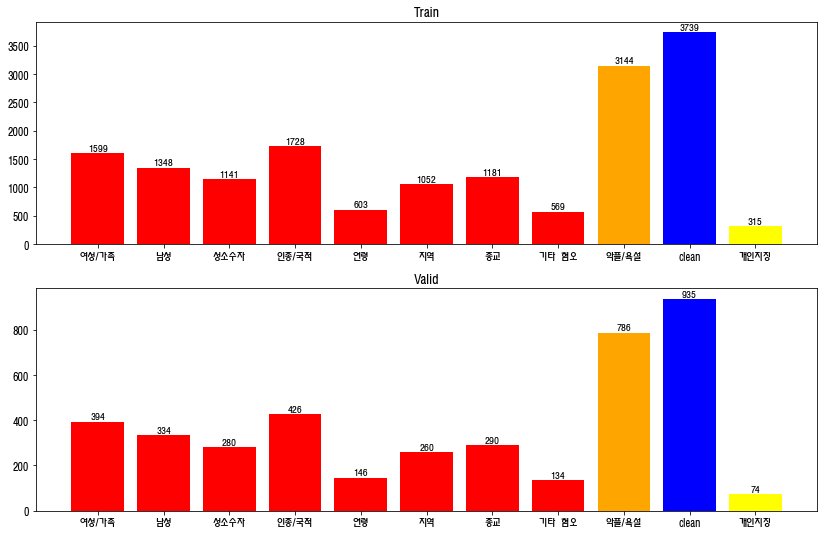

<Figure size 432x288 with 0 Axes>

In [9]:
# train data와 valid data의 카테고리 별 데이터 수 시각화
colors = ['red','red','red','red','red','red','red','red','orange', 'blue', 'yellow']
plt.figure(figsize=(14,9)); plt.subplot(2,1,1); plt.title('Train'); plt.bar(train_table.columns.values, train_table.values.reshape(11,), color=colors)
for i, v in enumerate(train_table.columns.values):
    plt.text(v, train_table.values.reshape(11,)[i], train_table.values.reshape(11,)[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, color='black',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)
plt.subplot(2,1,2); plt.title('Valid'); plt.bar(valid_table.columns.values, valid_table.values.reshape(11,), color=colors)
for i, v in enumerate(valid_table.columns.values):
    plt.text(v, valid_table.values.reshape(11,)[i], valid_table.values.reshape(11,)[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, color='black',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)
plt.show(); plt.close('all'); plt.clf()

Text(0.5, 1.0, 'Correlation ')

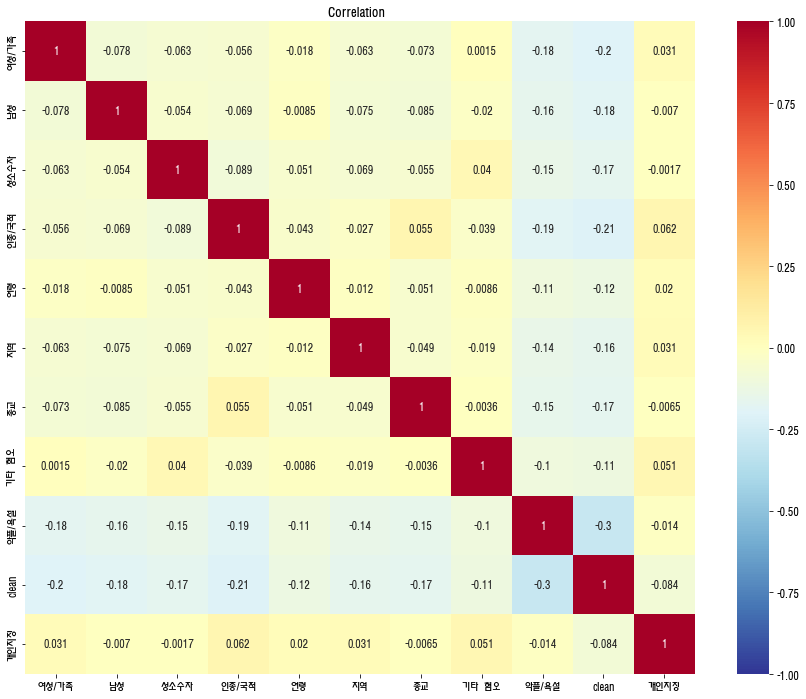

In [10]:
# Feature들 간의 상관간계 확인
corr = train_df.corr()
fig = plt.figure(figsize=(15,12))
r = sns.heatmap(corr, cmap = 'RdYlBu_r', vmin = -1, vmax = 1, annot=True)
r.set_title("Correlation ")

In [11]:
# 클린과 악성문장 간에 음의 상관관계를 갖는 것 외에는 딱히 유의미한 정보가 없다. 
# 악성 문장들끼리는 악성이니 당연히도 약한 양의 상관관계를 갖는다.
# 개인 지칭은 악성 문장에만 태깅 되었음에도 clean과 음의 상관관계를 띄지 않는다. -- 왜?